In [1]:
# jupyter notebook go wide screen
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



In [2]:
import scipy.stats as stats
import numpy as np
import astropy.units as u
from astropy.io import ascii
from scipy.integrate import quad
import time
import pymc3 as pm
import theano.tensor as tt
import glob
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import scipy.stats as stats

In [4]:
def efunc(z, om, ol):
	return (om*(1+z)**3+ol)**(-1./2)

def integral(z, omega_m, omega_lambda):
	return quad(efunc, 0, z, args=(omega_m, omega_lambda))

def DA(z, h=0.674, omega_m=0.315, omega_lambda=0.685):
	Dh = 3000 * 1/h * u.Mpc 
	return Dh/(1+z)*integral(z, omega_m, omega_lambda)

def kpc_proper_per_deg(z, h=0.674, omega_m=0.315, omega_lambda=0.685):
	return np.pi/(648000)*3600*DA(z, h=0.674, omega_m=0.315, omega_lambda=0.685).to(u.kpc)

def arcsec_to_pkpc(n):
    return kpc_proper_per_deg(2.5)*n/3600. # n arcsec in proper kpc 

def moffat3(xygrid, x0, y0, f0, fwhm):
    x, y = xygrid
    rsq = (x-x0)**2 + (y-y0)**2
    gamma = fwhm/(2 * np.sqrt(2**(1/3.)-1))
    return f0 * (1 + rsq / gamma**2)**(-3)

def moffat_radec(ras, decs, midra, middec, f0, fwhm, index): # fwhm in degrees!
    deccos = np.cos(middec*np.pi/180)
    rsq = ((ras-midra)*deccos)**2 + (decs-middec)**2
    gamma = fwhm/(2 * np.sqrt(2**(1/index)-1))
    return f0 * (1 + rsq / gamma**2)**(-index)

def pretty_time_delta(seconds):
    sign_string = '-' if seconds < 0 else ''
    seconds = abs(int(seconds))
    days, seconds = divmod(seconds, 86400)
    hours, seconds = divmod(seconds, 3600)
    minutes, seconds = divmod(seconds, 60)
    if days > 0:
        return '%s%dd%dh%dm%ds' % (sign_string, days, hours, minutes, seconds)
    elif hours > 0:
        return '%s%dh%dm%ds' % (sign_string, hours, minutes, seconds)
    elif minutes > 0:
        return '%s%dm%ds' % (sign_string, minutes, seconds)
    else:
        return '%s%ds' % (sign_string, seconds)


# Plan

1. fit amplitude non-hierarchichal, normal distribution
2. fit amplitude non-hierarchical, lognormal distribution
3. fit amplitude hierarchical, lognormal distribution

1. fit fwhm non-hierarchical, normal
2. fit fwhm non-hierarchical, lognormal
3. fit fwhm hierarchical, lognormal (I don't even know if this is the right thing to do)

$\rightarrow$ same with offset

$\rightarrow$ also fit index (I don't know if hierarchical would be good)

In [5]:
def distsq(midra, middec, ras, decs):
    
    """returns the angular distances in arcseconds"""
    
    deccos = np.cos(middec*np.pi/180.)
    return (((ras-midra)*deccos)**2 + (decs-middec)**2)*(3600)**2

def moffat_arcsec(rsq, amp, index, fwhm):#, offset=0):
    
    """returns the moffat function with alpha=index and fwhm in arcseconds."""
    #fwhm = 1.77
    gamma = fwhm/(2 * np.sqrt(2**(1/index)-1))
    return amp * (1 + rsq / gamma**2)**(-index) #+ offset

(2.8046947671371347, 1.3565831470807321)

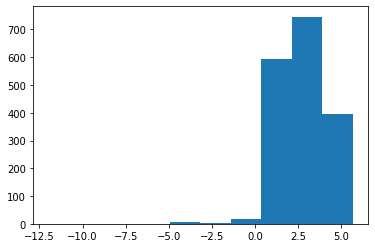

In [6]:
fit_res = ascii.read("fit_results.tab")
plt.hist(np.log(fit_res["amp"]))
np.nanmedian(np.log(fit_res["amp"])), np.nanstd(np.log(fit_res["amp"]))

In [7]:
###################################################
#  try from scratch
###################################################

N_stars = 100
N_steps = 10000

flux_real = stats.lognorm.rvs(s = 1.4, scale=np.exp(2.8), size=N_stars)
fwhm_real = 1.7
index_real = 3.9
offset_real = 0.0


#plt.hist(np.log(fit_res["amp"]), alpha=0.5, density=True)
#plt.hist(np.log(flux_real), alpha=0.5, density=True)

stars = glob.glob("new_startabs/*")
starmids = []
stardists = []
starflux = []
i = 0
for sf in stars:
    a = ascii.read(sf)
    midra, middec = a[0]["star_ra"], a[0]["star_dec"]
    a = a[np.isfinite(a["flux"])&(a["flux"]!=0.0)]
    if len(a)<1:
        continue
        
    rsq = distsq(a[0]["star_ra"], a[0]["star_dec"], a["ra"].data, a["dec"].data) # in arcseconds
    a = a[np.sqrt(rsq) < 13.]
    rsq = rsq[np.sqrt(rsq) < 13.]
    if len(rsq)<100:
        continue
    elif np.nanmin(rsq)>1.5**2:
        continue
    order = np.argsort(rsq)[:100]
    rsq = rsq[order]
    a = a[order]
    stardists.append(rsq)
    starflux.append(moffat_arcsec(rsq, flux_real[i], index_real, fwhm_real) + np.random.normal(loc=0.0, scale=0.1, size=len(rsq)))
    if False:
        plt.figure()
        plt.plot(np.sqrt(rsq), starflux[i])
    i+=1
    if i == N_stars:
        break

In [12]:
with pm.Model() as model:
    
    fwhm = fwhm_real
    index = index_real
    
    #flux_mid = pm.Normal("mu_f0", mu=2.8, sd=1.0)
    #flux_scale = pm.Uniform("sd_f0", 0.1, 4.0)
    #flux_log = pm.Normal("logf0_off", mu=0.0, sd=1.0, shape=N_stars)
    #flux = pm.Deterministic("f0", tt.exp((flux_log + flux_mid)*flux_scale))
    flux = pm.Lognormal("f0", mu=2.8, sd=1.4, shape=N_stars)
    
    rsquared = stardists
    
    flux_error = 0.1
    
    gammasq = fwhm**2/(4 * (2**(1/index)-1))
    out_flux = tt.stack([flux[i] * (1 + rsquared[i]/gammasq)**(-index) for i in range(N_stars)])
    
    observation = pm.Normal("obs", mu=out_flux, sd=flux_error, observed=starflux)

In [ ]:
with model:
    ######### Run, run run!!! #####################
    
    # csv files as backend
    # we have to do this after defining the model
    db = pm.backends.Text('mcmctest')
    trace = pm.sample(N_steps, trace=db) # step=step, 
    burned_trace=trace[1000:]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f0]
Sampling 4 chains, 22 divergences:  12%|█▏        | 5224/42000 [07:51<2:13:29,  4.59draws/s]

In [ ]:
pm.plot_posterior(burned_trace["mu_f0"])
pm.plot_posterior(burned_trace["sd_f0"])

/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`

/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`

/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`

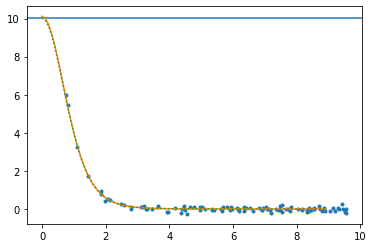

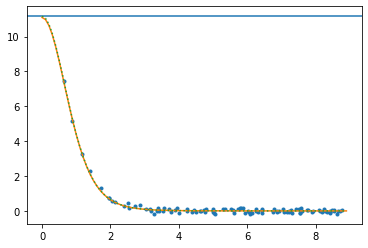

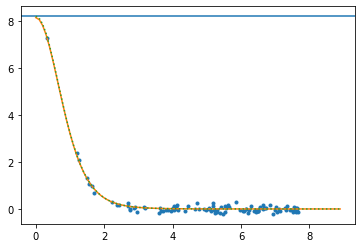

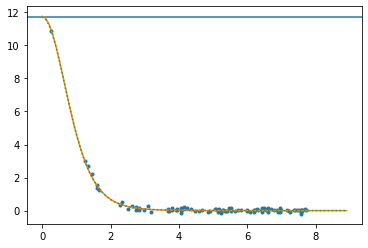

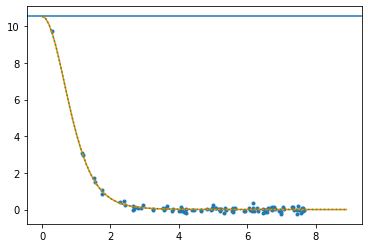

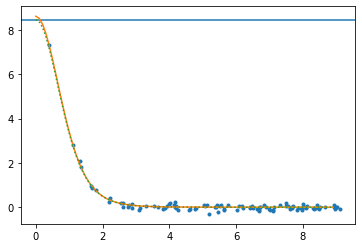

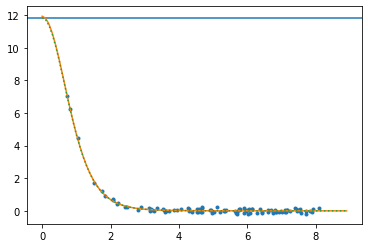

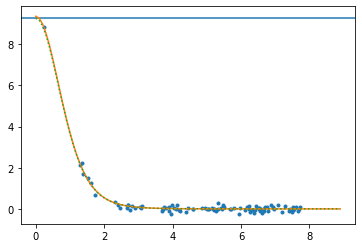

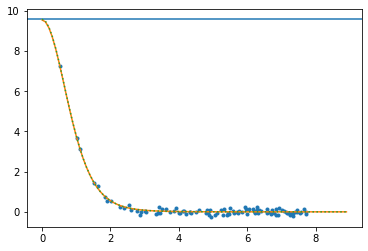

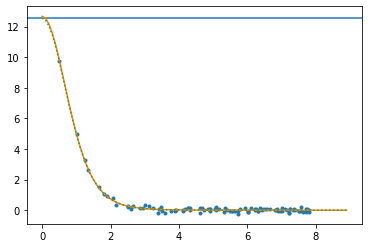

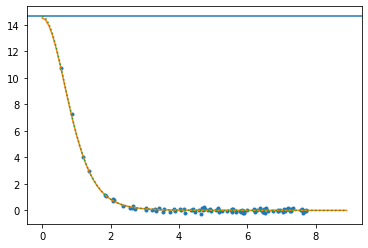

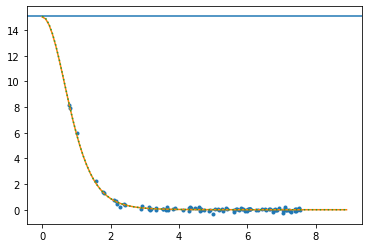

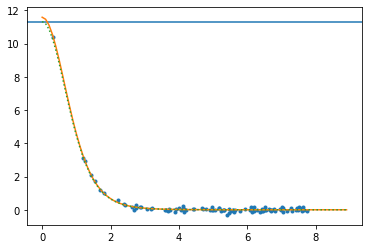

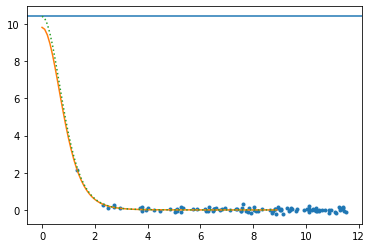

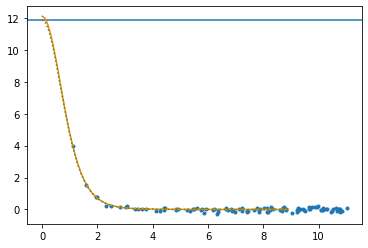

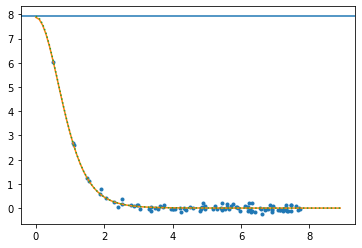

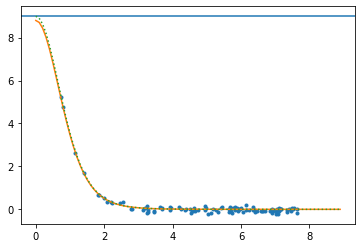

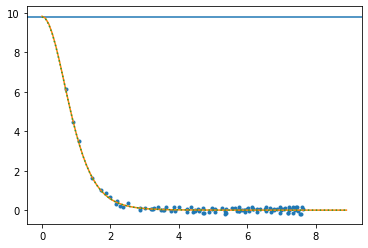

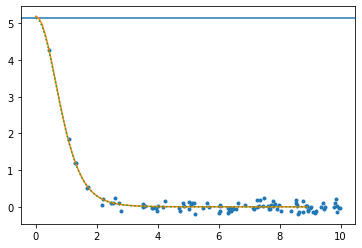

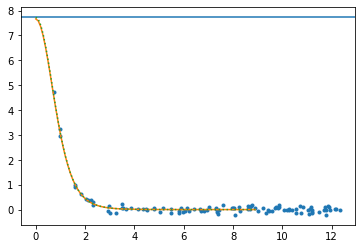

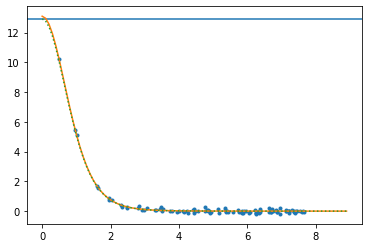

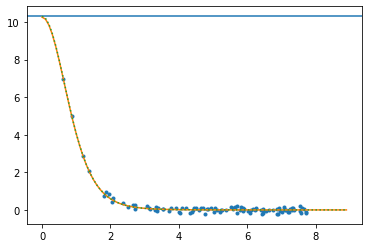

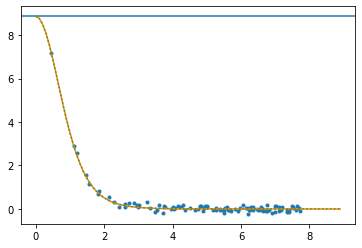

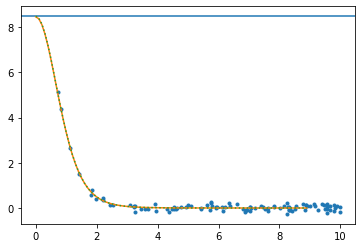

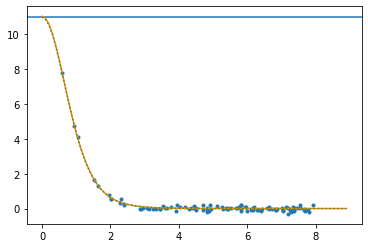

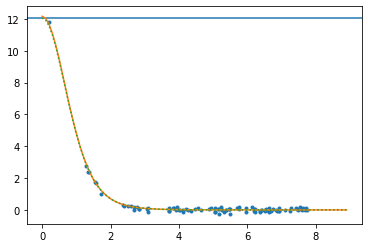

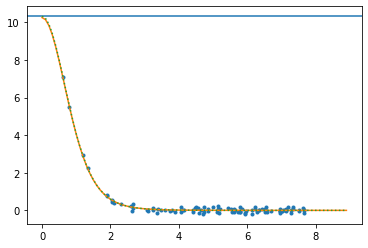

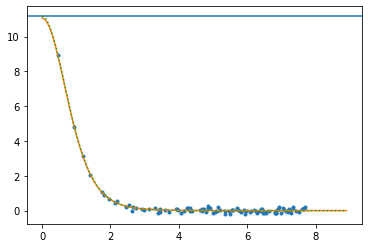

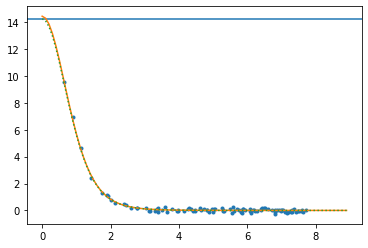

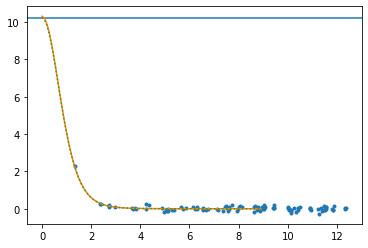

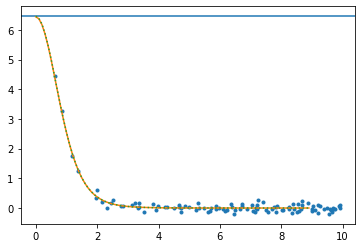

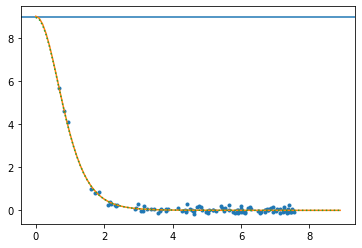

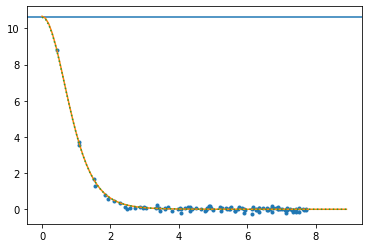

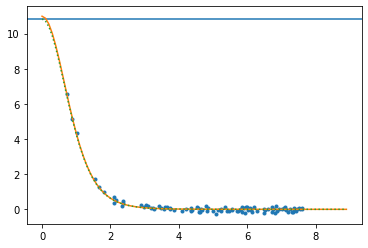

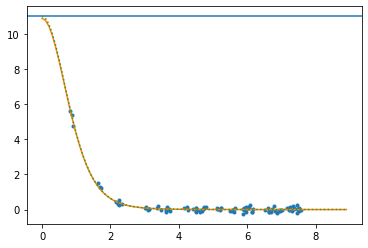

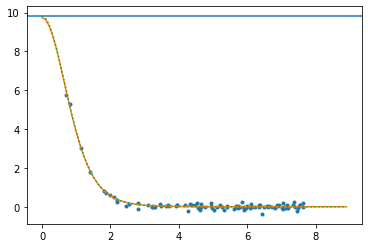

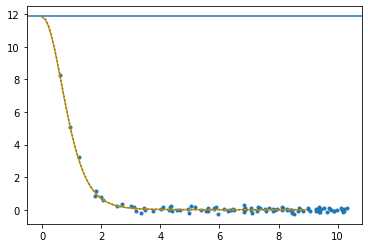

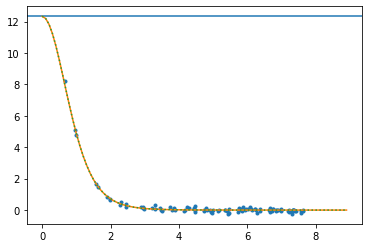

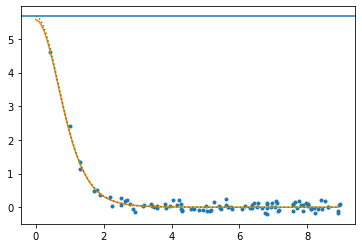

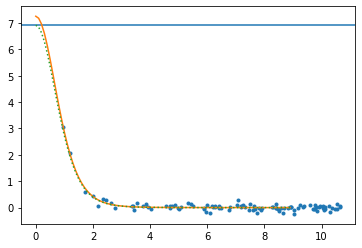

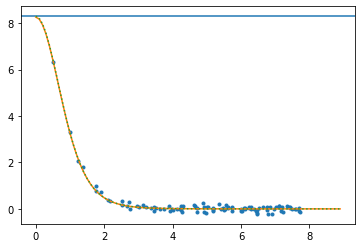

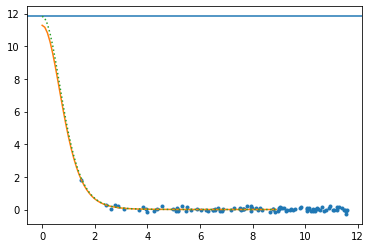

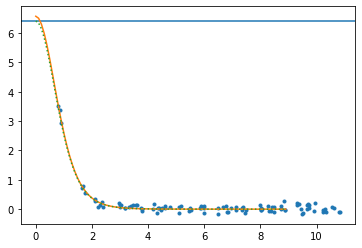

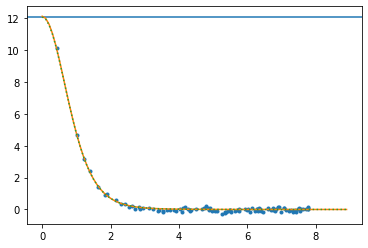

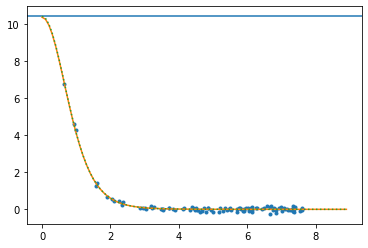

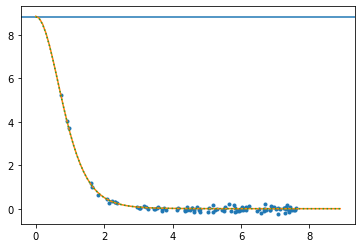

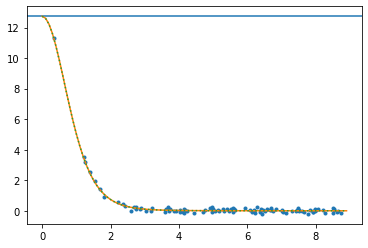

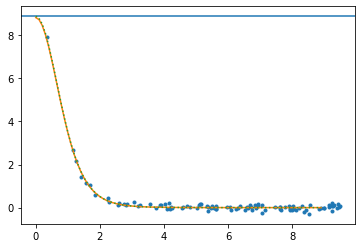

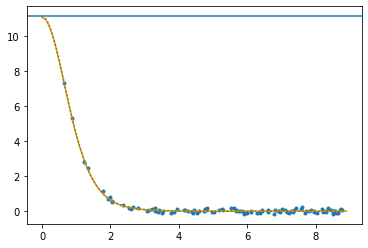

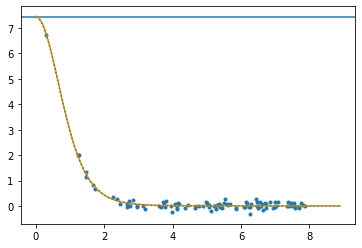

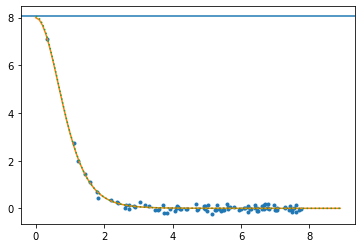

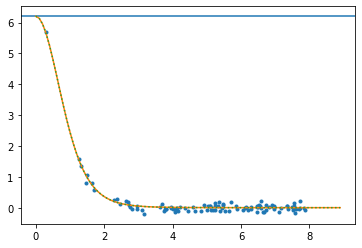

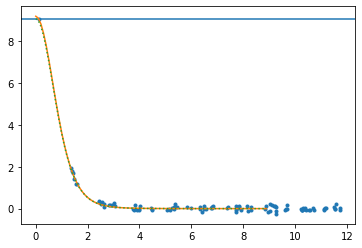

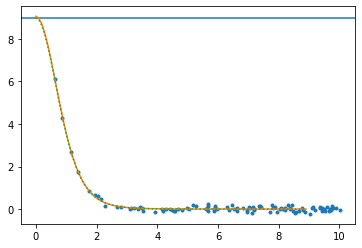

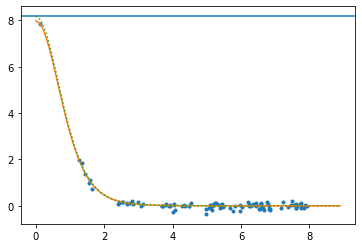

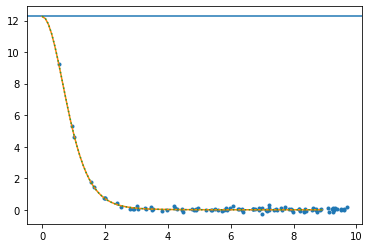

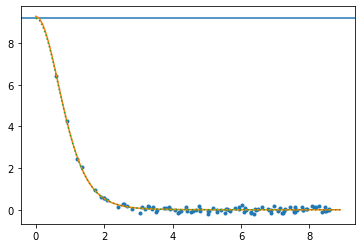

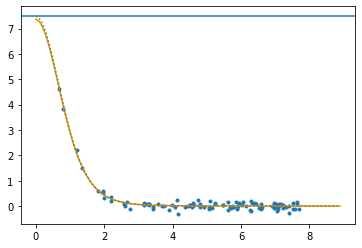

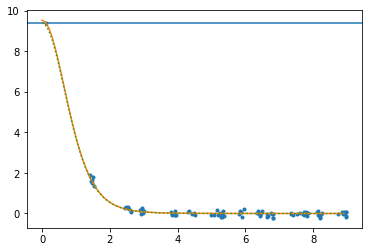

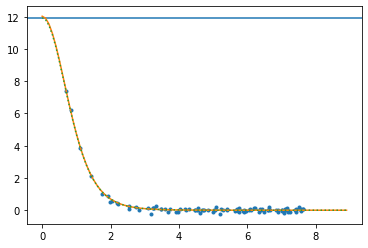

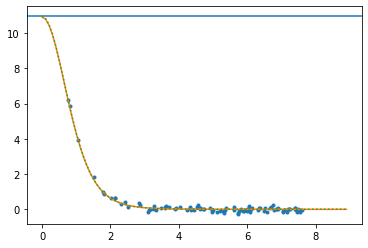

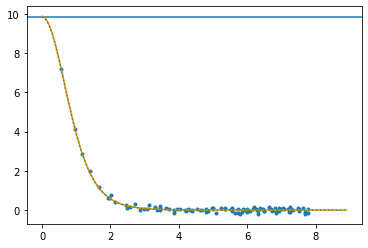

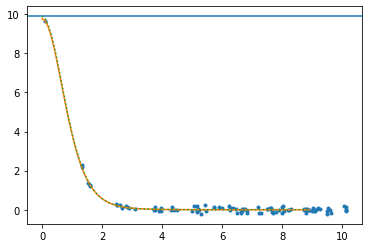

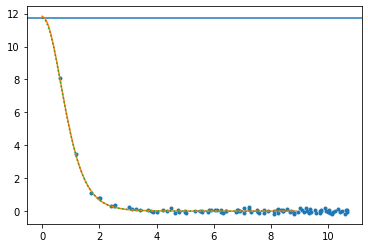

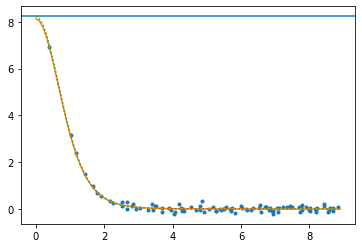

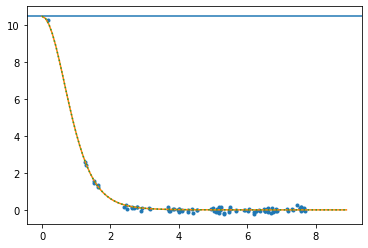

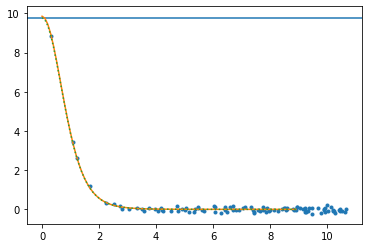

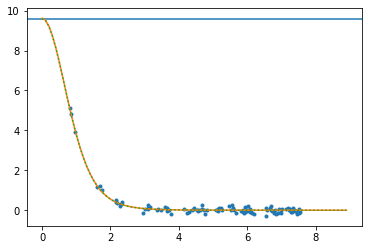

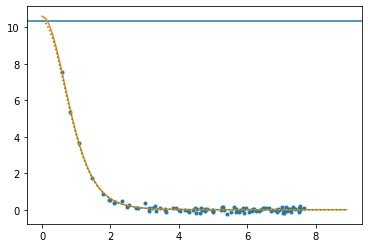

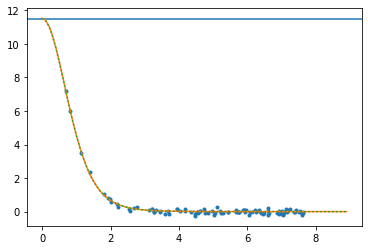

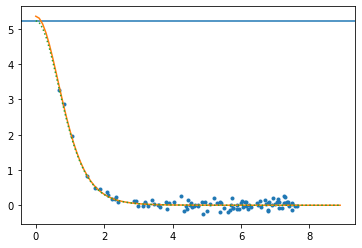

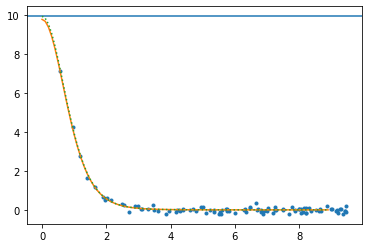

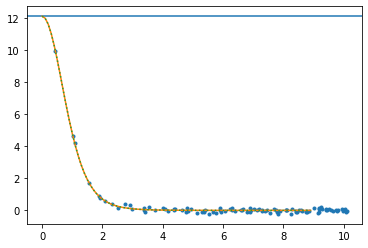

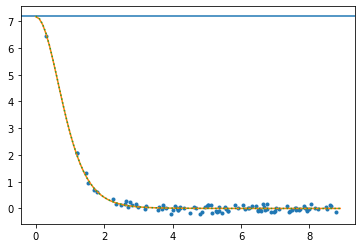

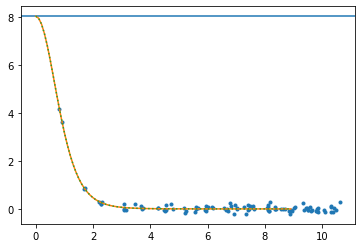

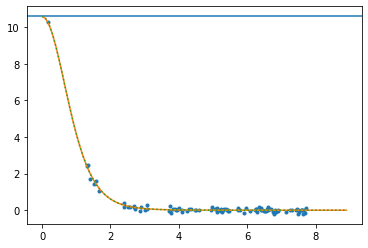

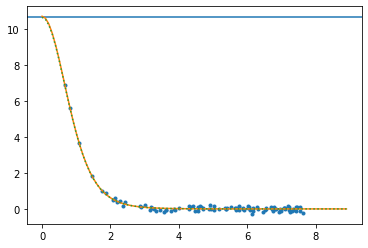

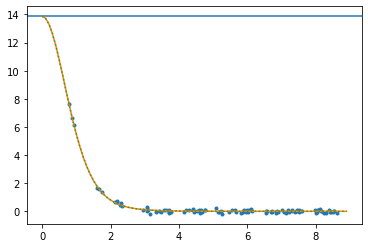

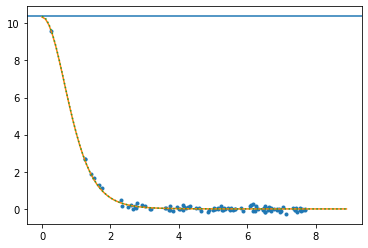

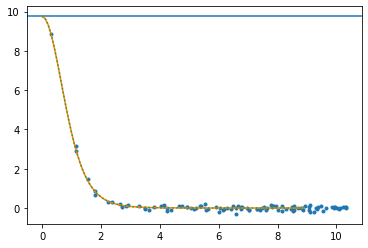

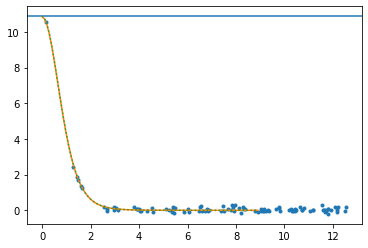

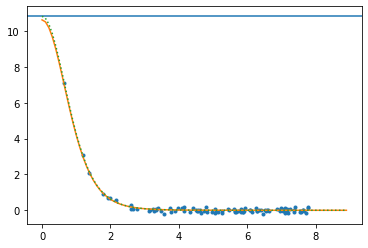

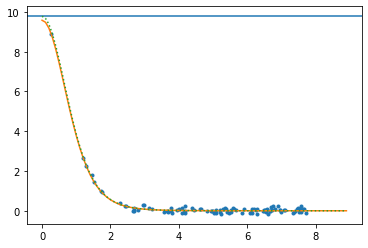

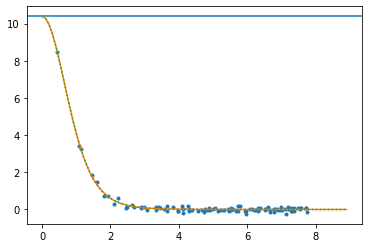

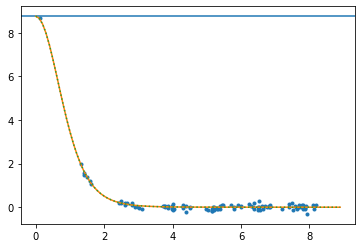

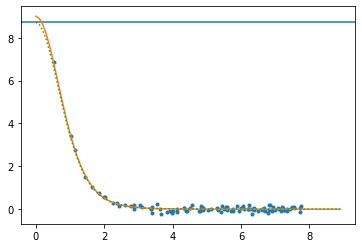

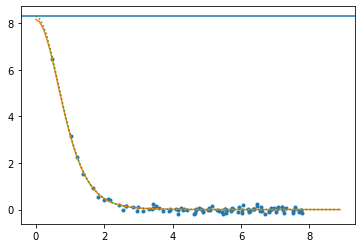

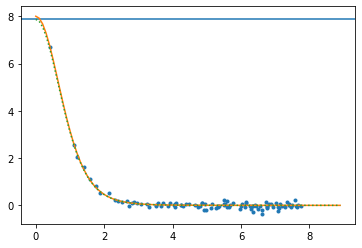

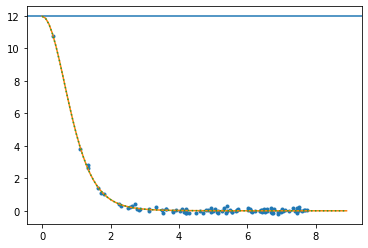

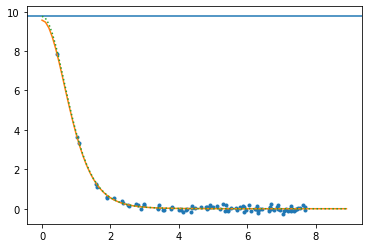

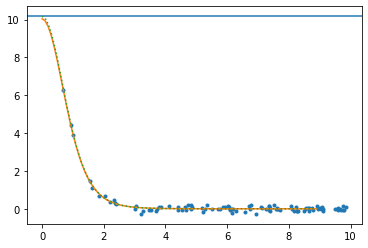

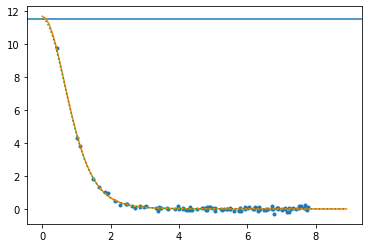

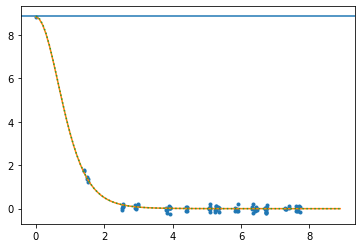

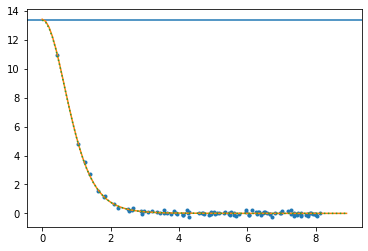

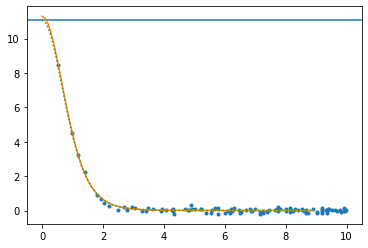

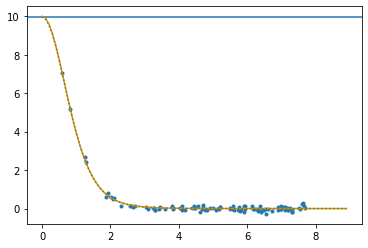

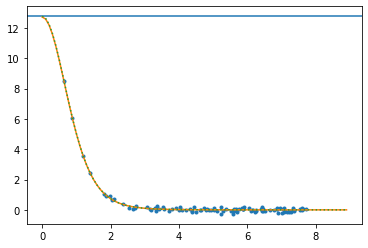

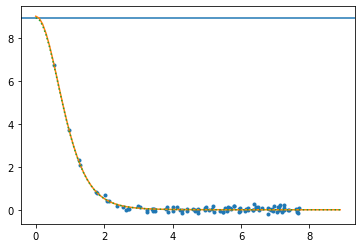

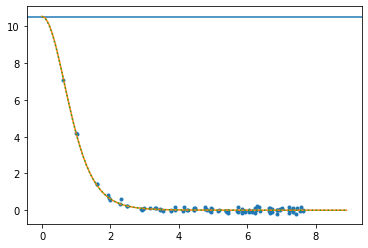

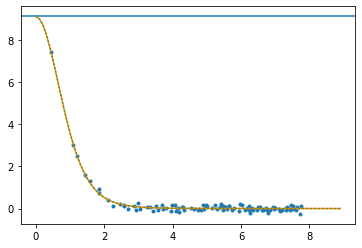

In [33]:
testdists = np.arange(0, 9, 0.1)
gammasq = fwhm_real**2/(4 * (2**(1/index_real)-1))
for i in range(N_stars):
    plt.figure()
    plt.plot(np.sqrt(stardists[i]), starflux[i], ".")
    plt.axhline(flux_real[i])
    plt.plot(testdists, np.nanmean(chain["f0__{}".format(i)]) * (1 + testdists**2/gammasq)**(-index_real))
    
    plt.plot(testdists, flux_real[i] * (1 + testdists**2/gammasq)**(-index_real), linestyle=":")

In [31]:
import pandas as pd

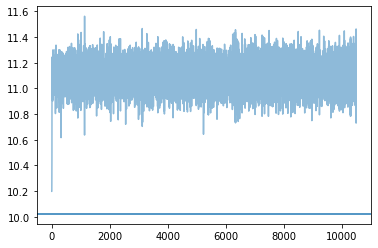

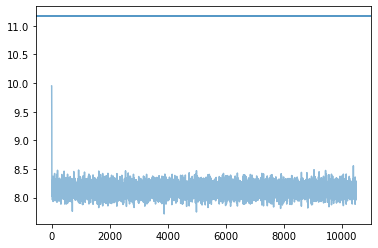

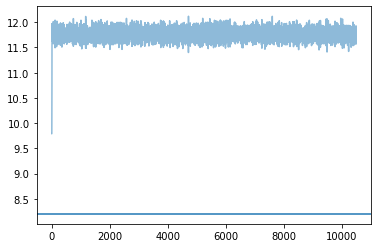

In [32]:
chain = pd.read_csv("mcmctest/chain-2.csv")
for i in range(3):
    plt.figure()
    plt.plot(chain["f0__{}".format(i+1)], alpha=0.5)
    plt.axhline(flux_real[i])

In [5]:
###################################################
###_________Define and run the model____________###
###################################################

with pm.Model() as model:
    
    ##### Priors ###################################
    # priors for fwhm distribution
    mu_fwhm = pm.Uniform("mu_fwhm", 0.1, 1.0)          # mean(log(fwhm/arcsec))
    sigma_fwhm = pm.Uniform("sigma_fwhm", 0.05, 0.5)    # std(log(fwhm/arcsec))
    
    mu_f0 = pm.Uniform("mu_f0", 0.5, 5.0)
    sigma_f0 = pm.Uniform("sigma_f0", 0.001, 1.0)
    
    # priors and values for x0, y0 distributions (make them equal)
    mu_x0 = 0.0 
    sigma_x0 = 0.5 #pm.Uniform("sigma_x0", 0.1, 5)      # in arcsec
   
    log_fwhm_offset = pm.Normal("log_fwhm_offset", mu=0.0, sd=1.0, shape=N_stars) 
    fwhm = pm.Deterministic("fwhm", tt.exp(mu_fwhm + log_fwhm_offset * sigma_fwhm))  
    #fwhm = pm.Deterministic("fwhm", tt.exp(log_fwhm))
    
    f_0_offset = pm.Normal("f_0_offset", mu=0.0, sd=1.0, shape=N_stars)
    f_0 = pm.Deterministic("f_0", tt.exp(mu_f0 + f_0_offset * sigma_f0))   # in 1e-17 erg/s/cm^2
    
    del_ra_offset = pm.Normal("del_ra_offset", mu=0.0, sd=1.0, shape=N_stars)
    del_dec_offset = pm.Normal("del_dec_offset", mu=0.0, sd=1.0, shape=N_stars)

    #del_ra_0 = pm.Normal("del_ra_0", mu=mu_x0, sd=sigma_x0, shape=N_stars)   # I need to change this to /cos(dec)
    #del_dec_0 = pm.Normal("del_dec_0", mu=mu_x0, sd=sigma_x0, shape=N_stars) 

    deccos = tt.cos(guess_decs * PI/180.)
    ra_0 = guess_ras + del_ra_offset * sigma_x0 / 3600. / deccos
    dec_0 = guess_decs + del_dec_offset * sigma_x0 / 3600. 
   
    rsq = tt.stack([((all_ras[i]-ra_0[i])*deccos[i])**2 + (all_decs[i]-dec_0[i])**2 for i in range(N_stars) ])
    gamma = fwhm/divnum
    
    # define model for flux
    flux = tt.stack([f_0[i] * (1 + rsq[i] / gamma[i]**2)**(-3) for i in range(N_stars)])
    # and error
    flux_sd = 0.05
    
    # include observation (likelihood)
    observation = pm.Normal("obs", mu = flux, sd = flux_sd, observed=f_data)


In [6]:
with model: 
        
    ######### Run, run run!!! #####################
    
    # csv files as backend
    # we have to do this after defining the model
    db = pm.backends.Text('mcmctest')
    trace = pm.sample(N_steps, trace=db) # step=step, 
    burned_trace=trace[1000:]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [del_dec_offset, del_ra_offset, f_0_offset, log_fwhm_offset, sigma_f0, mu_f0, sigma_fwhm, mu_fwhm]
Sampling 4 chains, 0 divergences:   6%|▌         | 1538/26000 [00:08<22:42, 17.95draws/s] INFO (theano.gof.compilelock): Waiting for existing lock by process '104742' (I am process '104740')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/05865/maja_n/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.4.1708-Core-x86_64-3.7.0-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '104742' (I am process '104743')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/05865/maja_n/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.4.1708-Core-x86_64-3.7.0-64/lock_dir
Sampling 4 chains, 0 divergences:   6%|▌         | 1542/26000 [00:21<6:49:20,  1.00s/draws]INFO (theano.gof.comp

RuntimeError: Chain 2 failed.

In [ ]:
###################################################
###________Print the results____________________###
###################################################    
end_time = time.time()
print(pm.summary(burned_trace))
print("\n")

print("""## Run 
* **Idea**:  
* **N_stars** = {}
* **grid size** = {} 
* **samples** = {}
* **n_files x file size** = 4 x 
* **warning**:
* **Run time**: {}
* **Notes**: 
    - FWHM: mu:  (real: {:.2f}), sigma:  (real: {:.2f})
    - f_0: mu:  (real: {:.2f}), sigma:  (real {:.2f})
    - sigma_x0:  (real: {:.2f})
* **Interpretation**: """.format(N_stars, all_ras.shape[1], N_steps, pretty_time_delta(end_time-begin_time), MID_FWHM, SCALE_FWHM, MID_AMP, SCALE_AMP, sigma_x0_real))
